In [1]:
# !pip install --upgrade pip
# !pip install pandas
# !cp ./fp_refined.csv /data

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


import pandas as pd

from tqdm import tnrange, tqdm_notebook

In [3]:
path_csv = "/data/fp_refined.csv"
df = pd.read_csv(path_csv)
df

,id_after,Path,index,APT_ID,Date,year,norm_year,yyyymm,N_Housings,Max_Floors,...,sido_cluster_code,sido_sgg_name,FP_ID,Area,norm_log_area,area_85,Entrance,Rooms,Baths,N_Units
0,8928_160,/data/fp_img_processed/8928_160.png,1,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,160,134.30,1.313282,False,계단식,4,2,84
1,8928_183,/data/fp_img_processed/8928_183.png,2,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,183,153.80,1.702528,False,계단식,4,2,44
2,8928_201A,/data/fp_img_processed/8928_201A.png,3,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,201A,170.32,1.995448,False,계단식,4,2,42
3,8928_204B,/data/fp_img_processed/8928_204B.png,4,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,204B,168.42,1.963240,False,계단식,4,2,42
4,960_35,/data/fp_img_processed/960_35.png,5,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,35,35.64,-2.495452,False,계단식,2,1,530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50535,115454_21D,/data/fp_img_processed/115454_21D.png,50577,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,21D,14.50,-5.077429,False,계단식,2,1,20
50536,115454_34E,/data/fp_img_processed/115454_34E.png,50578,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,34E,21.57,-3.937185,False,계단식,2,1,4
50537,115454_36B,/data/fp_img_processed/115454_36B.png,50579,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,36B,24.86,-3.529623,False,계단식,3,2,16
50538,115454_37A,/data/fp_img_processed/115454_37A.png,50580,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,37A,25.67,-3.437569,False,계단식,3,2,24


In [4]:
df_image = pd.read_csv("processed.csv")
df_image

,ID
0,3803_145
1,112076_61B1d
2,1200_85A
3,2604_104(동신)
4,3039_154B
...,...
50407,12238_105B
50408,103025_83A3
50409,23002_108
50410,772_156


In [5]:
df = df[df.id_after.isin(df_image.ID)]
df

,id_after,Path,index,APT_ID,Date,year,norm_year,yyyymm,N_Housings,Max_Floors,...,sido_cluster_code,sido_sgg_name,FP_ID,Area,norm_log_area,area_85,Entrance,Rooms,Baths,N_Units
0,8928_160,/data/fp_img_processed/8928_160.png,1,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,160,134.30,1.313282,False,계단식,4,2,84
1,8928_183,/data/fp_img_processed/8928_183.png,2,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,183,153.80,1.702528,False,계단식,4,2,44
2,8928_201A,/data/fp_img_processed/8928_201A.png,3,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,201A,170.32,1.995448,False,계단식,4,2,42
3,8928_204B,/data/fp_img_processed/8928_204B.png,4,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,204B,168.42,1.963240,False,계단식,4,2,42
4,960_35,/data/fp_img_processed/960_35.png,5,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,35,35.64,-2.495452,False,계단식,2,1,530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50535,115454_21D,/data/fp_img_processed/115454_21D.png,50577,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,21D,14.50,-5.077429,False,계단식,2,1,20
50536,115454_34E,/data/fp_img_processed/115454_34E.png,50578,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,34E,21.57,-3.937185,False,계단식,2,1,4
50537,115454_36B,/data/fp_img_processed/115454_36B.png,50579,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,36B,24.86,-3.529623,False,계단식,3,2,16
50538,115454_37A,/data/fp_img_processed/115454_37A.png,50580,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,...,8,제주도 제주시,37A,25.67,-3.437569,False,계단식,3,2,24


In [6]:
def read_mono_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    mono = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return mono


def fp_float_from_mono(mono):
    """create 0 or 1 binary mask image from 
    wall/entrance/LDK/bedroom/balcony/bathroom stacked array"""

    # AREA_WALL = 64
    # AREA_ENTRANCE = 32
    # AREA_LDK = 16
    # AREA_BEDROOM = 8
    # AREA_BALCONY = 4
    # AREA_BATHROOM = 2

    mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)
    mask = np.broadcast_to(mask_bits, (*mono.shape[:2], 6))

    unit_comb = (((np.expand_dims(mono, 2) & mask) > 0)).astype(np.float)

    return unit_comb


def pad_fp(fp, width=112, height=112):
    """place the fp at the bottom center of padded image."""
    h, w = np.subtract(fp.shape[:2], (height, width))
    if h > 0:
        fp = fp[h : h + height, :, :]
    if w > 0:
        fp = fp[:, w // 2 : w // 2 + width, :]

    h, w = np.subtract((height, width), fp.shape[:2])
    fp = np.pad(fp, ((max(h, 0), 0), (max(w // 2, 0), max(w - w // 2, 0)), (0, 0)))
    return fp


def visualize_fp(fps):
    # adjusted for different luminance
    channel_to_rgba = np.array(
        [
            [0.0, 0.0, 0.0, 0.0],  # wall to black L0
            [0.0, 0.33, 0.0, 0.0],  # entrance to green L30
            [1.0, 0.25, 0.0, 0.0],  # LDK to red L57
            [0.83, 0.87, 0.0, 0.0],  # bedroom to yellow L85
            [0.0, 0.26, 1.0, 0.0],  # balcony to blue L40
            [0.0, 0.81, 0.76, 0.0],  # bathroom to cyan L75
        ]
    )

    # make colors subtractive
    channel_to_rgba[:, 0:3] -= 1

    # put it on white
    fps_rgba = np.clip(
        np.array([1.0, 1.0, 1.0, 1.0]) + (np.array(fps) @ channel_to_rgba), 0, 1
    )
    return fps_rgba


# def _fp_from_string(bytes):
#     return np.frombuffer(bytes).reshape(28,28,6)

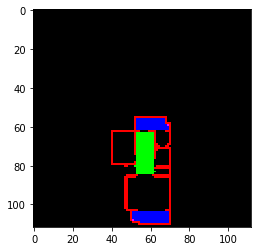

In [7]:
# 10001_57B
# 2112_49_0
mono = read_mono_from_image_unicode("/data/fp_img_processed/2112_49_0.png")
fp = fp_float_from_mono(mono)
fp = pad_fp(fp)
plt.imshow(fp[..., [0, 2, 4]])

In [8]:
def preprocess_fp(path):
    mono = read_mono_from_image_unicode(path)
    fp = fp_float_from_mono(mono)
    fp = pad_fp(fp)
    return fp

In [9]:
fp.shape, fp.dtype, np.amax(fp)

((112, 112, 6), dtype('float64'), 1.0)

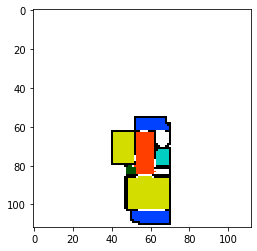

In [10]:
plt.imshow(visualize_fp(fp))

In [11]:
def preprocess_year(year):
    return max(0, (year - 1970) // 5)

In [12]:
print([preprocess_year(year) for year in range(1969, 2022)])

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10]


In [13]:
df_tfrecord = df.loc[
    :,
    [
        "Path",
        "id_after",
        "year",
        "sido_cluster_code",
        "norm_log_area",
        "Rooms",
        "Baths",
    ],
]
df_tfrecord

,Path,id_after,year,sido_cluster_code,norm_log_area,Rooms,Baths
0,/data/fp_img_processed/8928_160.png,8928_160,2004,0,1.313282,4,2
1,/data/fp_img_processed/8928_183.png,8928_183,2004,0,1.702528,4,2
2,/data/fp_img_processed/8928_201A.png,8928_201A,2004,0,1.995448,4,2
3,/data/fp_img_processed/8928_204B.png,8928_204B,2004,0,1.963240,4,2
4,/data/fp_img_processed/960_35.png,960_35,1982,0,-2.495452,2,1
...,...,...,...,...,...,...,...
50535,/data/fp_img_processed/115454_21D.png,115454_21D,2017,8,-5.077429,2,1
50536,/data/fp_img_processed/115454_34E.png,115454_34E,2017,8,-3.937185,2,1
50537,/data/fp_img_processed/115454_36B.png,115454_36B,2017,8,-3.529623,3,2
50538,/data/fp_img_processed/115454_37A.png,115454_37A,2017,8,-3.437569,3,2


In [14]:
rows = df_tfrecord.sample(frac=1).values

# The following functions can be used to convert a value to a type compatible
# with tf.Example.
# https://www.tensorflow.org/tutorials/load_data/tf_records


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _floats_array_feature(value):
    """Returns a float_list from a numpy array of floats / doubles."""
    # https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1)))


def _int64s_array_feature(value):
    """Returns an int64_list from a numpy array of ints."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value.reshape(-1)))

In [15]:
# tf.train.Feature(float_list=tf.train.FloatList(value=processed.flatten()))

# _floats_array_feature(fp)

In [16]:
def serialize_example(row):
    """
    Creates a tf.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.

    fp = preprocess_fp(row[0])
    year = preprocess_year(row[2])
    feature = {
        "floorplan": _floats_array_feature(fp.reshape(-1)),
        "plan_id": _bytes_feature(row[1].encode("utf-8")),
        "year": _int64_feature(year),  # 0~9
        "sido": _int64_feature(row[3]),  # 0~8
        "norm_area": _float_feature(row[4]),
        "num_rooms": _int64_feature(row[5]),  # 1~7
        "num_baths": _int64_feature(row[6]),  # 1~5
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))

    return example_proto.SerializeToString()

In [17]:
example_proto = tf.train.Example.FromString(serialize_example(rows[0]))
print(repr(example_proto)[:100])
print(repr(example_proto)[-700:])

features {
  feature {
    key: "floorplan"
    value {
      float_list {
        value: 0.0
      
value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
      }
    }
  }
  feature {
    key: "norm_area"
    value {
      float_list {
        value: -5.016695499420166
      }
    }
  }
  feature {
    key: "num_baths"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "num_rooms"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "plan_id"
    value {
      bytes_list {
        value: "107230_33B-1"
      }
    }
  }
  feature {
    key: "sido"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "year"
    value {
      int64_list {
        value: 8
      }
    }
  }
}



In [18]:
path_all_tfrecord = "/data/fp.tfrecord"

options_gzip = tf.io.TFRecordOptions(
    compression_type="GZIP"
)

errors = []


for (path, rows) in zip([path_all_tfrecord], [rows]):
    with tf.io.TFRecordWriter(path=path, options=options_gzip) as writer:
        for row in tqdm_notebook(rows, desc="Processing plans"):
            try:
                serialized_example = serialize_example(row)
                writer.write(serialized_example)
            except:
                errors.append(row[1])


if errors:
    print(errors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [20]:
raw_dataset = tf.data.TFRecordDataset(path_all_tfrecord, compression_type="GZIP")
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [21]:
for raw_record in raw_dataset.take(2):  # WARNING: deprecated
    print(repr(raw_record)[:400])

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x95\xb1\x12\n\x12\n\tnum_rooms\x12\x05\x1a\x03\n\x01\x01\n\x97\xb0\x12\n\tfloorplan\x12\x88\xb0\x12\x12\x84\xb0\x12\n\x80\xb0\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00
<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x92\xb1\x12\n\x12\n\tnum_rooms\x12\x05\x1a\x03\n\x01\x03\n\x97\xb0\x12\n\tfloorplan\x12\x88\xb0\x12\x12\x84\xb0\x12\n\x80\xb0\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00


In [22]:
fp_dim = (112, 112, 6)


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            fp_dim, tf.float32, default_value=tf.zeros(fp_dim, tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "year": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "sido": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        "num_rooms": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    return parsed_example


parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {floorplan: (112, 112, 6), norm_area: (), num_baths: (), num_rooms: (), plan_id: (), sido: (), year: ()}, types: {floorplan: tf.float32, norm_area: tf.float32, num_baths: tf.int64, num_rooms: tf.int64, plan_id: tf.string, sido: tf.int64, year: tf.int64}>

In [23]:
for parsed_record in parsed_dataset.take(3):
    print(repr(parsed_record))

{'floorplan': <tf.Tensor: shape=(112, 112, 6), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        